In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import os
from collections import Counter
from itertools import product, chain
from tqdm import tqdm
from typing import *
import pickle
import json
from scipy.stats.distributions import beta, uniform
from sklearn.metrics import f1_score, precision_score, recall_score
from joblib import cpu_count

from InfluenceDiffusion.weight_samplers import make_weighted_cascade_weights
from InfluenceDiffusion.estimation_models.OptimEstimation import GLTGridSearchEstimator
from InfluenceDiffusion.estimation_models.EMEstimation import ICWeightEstimatorEM, LTWeightEstimatorEM
from InfluenceDiffusion.Graph import Graph
from InfluenceDiffusion.influence_models import LTM, GLTM, ICM
from InfluenceDiffusion.Trace import PseudoTraces, Traces

In [2]:
os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from utils.utils import multiple_union, plot_distribution
from utils.pseudo_trace_utils import compute_edge_stats_from_pseudo_traces, pseudo_trace_train_test_split
from benchmark_estimators import propagated_trace_proportion_weight_estimator
from utils.model_evaluation_utils import plot_roc_auc, plot_auprc

print("CPUs available:", cpu_count())

CPUs available: 8


## EM weight estimation

In [3]:
experiment_path = f"flixster_data/pseudo_traces_simplified/"

In [4]:
with open(os.path.join(experiment_path, "pseudo_traces.pkl"), "rb") as f:
    pseudo_traces = PseudoTraces(pickle.load(f))

In [5]:
trunc_edge_array = pd.read_csv("flixster_data/connected_comp_action_trunc_edge_df_new.csv").values
graph = Graph(np.vstack([trunc_edge_array, trunc_edge_array[:, [1, 0]]]))

del trunc_edge_array
print(graph.count_edges())

101030


In [6]:
n_cv_folds = 5

In [8]:
for i in range(n_cv_folds):
    fold_path = os.path.join(experiment_path, f"fold{i}")

    # os.mkdir(os.path.join(experiment_path, f"fold{i}"))

    train, test = pseudo_trace_train_test_split(pseudo_traces, test_prop=0.2,
                                                random_state=i)

    with open(os.path.join(fold_path, f"train_pseudo_traces.pkl"), "wb") as f:
        pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(fold_path, f"test_pseudo_traces.pkl"), "wb") as f:
        pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
param_grid = [beta(a, b) for a in range(1, 10) for b in range(1, 10)]
vertex_2_distrib_grid = {v: param_grid for v in graph.get_vertices()}

In [ ]:
for i in range(n_cv_folds):
    fold_path = os.path.join(experiment_path, f"fold{i}")

    if not os.path.isfile(os.path.join(fold_path, f"train_pseudo_traces.pkl")):
        print("Did not find train traces! Running train-test split!")
        train_pseudo_traces, _ = pseudo_trace_train_test_split(pseudo_traces, test_prop=0.2,
                                                               random_state=i)
    else:
        print("Found train traces!")
        with open(os.path.join(fold_path, f"train_pseudo_traces.pkl"), "rb") as f:
            train_pseudo_traces = PseudoTraces(pickle.load(f))
    
    # LT-EM model
    print("Working with LT-EM model!")
    lt_estimator = LTWeightEstimatorEM(graph, n_jobs=None)
    lt_estimator.fit(train_pseudo_traces, masks_path=None, 
                     verbose=True)
    np.save(os.path.join(fold_path, "train_lt_weights.npy"), lt_estimator.weights_)

    with open(os.path.join(fold_path, "activated_masks_tm1.pkl"), "wb") as f:
        pickle.dump(lt_estimator._vertex_2_active_parent_mask_tm1, f, 
                    protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(fold_path, "activated_masks_t.pkl"), "wb") as f:
        pickle.dump(lt_estimator._vertex_2_active_parent_mask_t, f, 
                    protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(fold_path, "failed_masks.pkl"), "wb") as f:
        pickle.dump(lt_estimator._failed_vertices_masks, f, 
                    protocol=pickle.HIGHEST_PROTOCOL)

    # GLT
    print("Working with GLT model!")
    gs_glt_estimator = GLTGridSearchEstimator(graph, 
                                              distribs_grid=vertex_2_distrib_grid,
                                              n_jobs=6)

    gs_glt_estimator.fit(train_pseudo_traces, masks_path=fold_path, verbose=True)

    np.save(os.path.join(fold_path, "train_glt_weights.npy"), 
            gs_glt_estimator.weights_)

    v_2_distirb_args = {v: distrib.args 
                        for v, distrib in gs_glt_estimator.vertex_2_distrib.items()}
    with open(os.path.join(fold_path, "train_glt_distrib_params.pkl"), "wb") as f:
        pickle.dump(v_2_distirb_args, f, protocol=pickle.HIGHEST_PROTOCOL)
    

    # PTP
    print("Working with PTP model!")
    ptp_weights = propagated_trace_proportion_weight_estimator(graph, train_pseudo_traces)
    np.save(os.path.join(fold_path, "train_ptp_weights.npy"), ptp_weights)

    # WC
    print("Working with WC model!")
    wc_weights = make_weighted_cascade_weights(graph)
    np.save(os.path.join(fold_path, "train_wc_weights.npy"), wc_weights)
    
    # IC
    print("Working with IC model!")
    icm_est = ICWeightEstimatorEM(graph, n_jobs=None)
    icm_est.fit(train_pseudo_traces, max_iter=100, tol=1e-7, verbose=True,
                masks_path=fold_path)
    np.save(os.path.join(fold_path, "train_icm_weights.npy"), icm_est.weights_)  

Found train traces!
Working with LT-EM model!


100%|██████████| 8174/8174 [07:58<00:00, 17.10it/s] 
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:   18.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:   22.9s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:   28.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:   34.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:   40.2s


Working with GLT model!


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 33.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 50.5min


In [12]:
def plot_indegs(graph_est):
    est_indegs = graph_est.get_all_indegrees(weighted=True)
    print("Prop non-zero indegs", np.mean(est_indegs > 1e-6))
    print("Median estim in-degree", np.median(est_indegs))
    counts, _, _ = plt.hist(est_indegs, bins=18)
    plt.xlabel("Estimated in-degree", fontsize=12)
    plt.ylabel("Count")
    plt.vlines(np.median(est_indegs), 0, np.max(counts), color="black", label="Median", linestyle="dashed")
    plt.show()

Prop non-zero indegs 0.7839602925809822
Median estim in-degree 0.09730105662342389


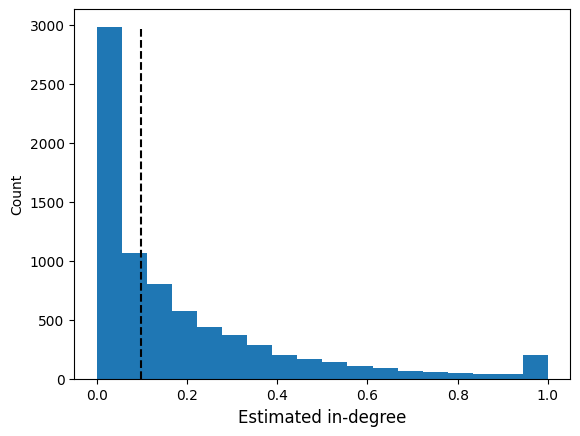

In [6]:
plot_indegs(graph_est)

## Compute test activation probabilities

In [13]:
from scipy.stats.distributions import uniform

def compute_test_activation_probs(test_pseudo_traces, est_graph, vertex_2_distrib=None, 
                                  if_icm=False):
    y_true = []
    p_preds = []
    
    if vertex_2_distrib is None:
        vertex_2_distrib = {v: uniform(0, 1) for v in est_graph.get_vertices()}
        
    for vertex, vertex_pseudo_traces in tqdm(test_pseudo_traces.items()):
        parent_mask = est_graph.get_parents_mask(vertex)
        parents = est_graph.edge_array[:, 0][parent_mask]
        parent_weights = est_graph.weights[parent_mask]
        for A_tm1, D_t in vertex_pseudo_traces:
            A_t = A_tm1 | D_t
            active_parent_mask = np.isin(parents, list(A_t))
            if if_icm:
                activ_prob = 1. - np.prod(1. - parent_weights[active_parent_mask])
            else:
                indeg = parent_weights[active_parent_mask].sum()
                activ_prob = vertex_2_distrib[vertex].cdf(indeg)
            p_preds.append(activ_prob)
            y_true.append(len(D_t) != 0)
            
    return np.array(y_true), np.array(p_preds)

In [ ]:
for i in range(n_cv_folds):
    
    fold_path = os.path.join(experiment_path, f"fold{i}")
    
    with open(os.path.join(fold_path, f"test_pseudo_traces.pkl"), "rb") as f:
        test_pseudo_traces = PseudoTraces(pickle.load(f))
            
    for model in ["lt", "glt", "wc", "ptp", "icm"]:
        
        print(f"Working with {model} model!")
        weights = np.load(os.path.join(fold_path, f"train_{model}_weights.npy"))
        weights = np.clip(weights, 0, 1)
        graph_est = deepcopy(graph).set_weights(weights)
        
        if model == "glt":
            node_params = np.load(os.path.join(fold_path, "train_glt_distrib_params.pkl"), allow_pickle=True)
            vertex_2_distrib = {v: uniform(0, 1) if args == (0, 1) else beta(*args) 
                               for v, args in node_params.items()}
        else:
            vertex_2_distrib = None
        
        y_test, p_pred = compute_test_activation_probs(test_pseudo_traces, graph_est, 
                                                       if_icm=model == "icm",
                                                       vertex_2_distrib=vertex_2_distrib)
        
        np.save(os.path.join(fold_path, f"p_pred_test_{model}.npy"), p_pred)
    
    np.save(os.path.join(fold_path, "y_test.npy"), y_test)
        

Working with lt model!


 51%|█████     | 4186/8174 [01:40<01:17, 51.70it/s]

In [30]:
model_path_keys = ["glt", "lt", "icm", "ptp", "wc"]
model_labels = ["GLT-Opt", "LT-EM", "IC-EM", "PTP", "WC"]
colors = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

ys = []
ps_over_models = {model: [] for model in model_labels}

for i in [1]:
    fold_path = os.path.join(experiment_path, f"fold{i}")
    
    for key, model in zip(model_path_keys, model_labels):
        p = np.load(os.path.join(fold_path, f"p_pred_test_{key}.npy"))
        ps_over_models[model].append(p)
        
    y = np.load(os.path.join(fold_path, "y_test.npy"))
    ys.append(y)

In [13]:
def binary_cross_entropy_loss(y, p, class_prop_weighted=False, weights=None, eps=1e-5):
    if weights is not None:
        weights = np.array(weights)
        assert len(weights) == 2
        assert np.all(weights >= 0)
    elif class_prop_weighted:
        weights = 1. / np.hstack([np.sum(y == 1),  np.sum(y == 0)])
    else:
        weights = np.ones(2)
    weights = weights / weights.sum()
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(weights[0] * y * np.log(p) + weights[1] * (1 - y) * np.log(1 - p))

In [ ]:
entropies_results = pd.DataFrame(columns=[f"fold {i}" for i in range(n_cv_folds)])

for model, ps in ps_over_models.items():
    cross_ents = [binary_cross_entropy_loss(y_test, p_pred)
                  for y_test, p_pred in zip(ys, ps)]
    entropies_results.loc[model] = cross_ents                   
    
entropies_results["mean"] = np.mean(entropies_results, 1)
entropies_results

In [31]:
def plot_metric_comparison_vs_threshold(y, ps, metric=f1_score, 
                                        thresholds=None, 
                                        labels=model_labels,
                                        colors=colors):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 20)[1:-1]
    
    assert len(labels) == len(ps)
    assert len(colors) == len(ps)
        
    metrics_over_models = [[metric(y, p > threshold) for threshold in thresholds] for p in ps]
    
    for model_metrics, label, color in zip(metrics_over_models, labels, colors):
    
        plt.plot(thresholds, model_metrics, label=label, c=color)
        
    plt.xlabel("Threshold")
    plt.ylabel(metric.__name__)
    plt.legend()

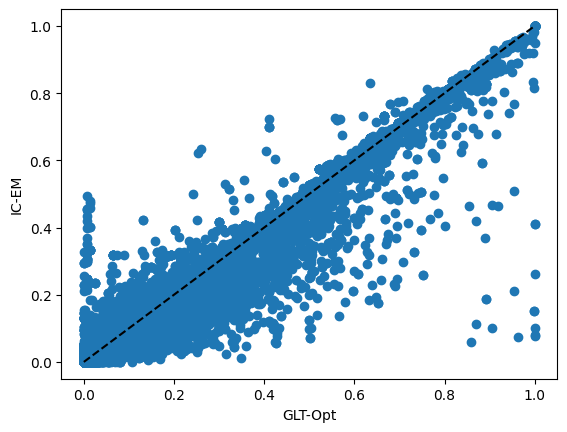

In [38]:
plt.scatter(ps_over_models["GLT-Opt"][0], ps_over_models["IC-EM"][0])
plt.xlabel("GLT-Opt")
plt.ylabel("IC-EM")
plt.plot([0, 1], [0, 1], linestyle="dashed", c="black")
plt.show()

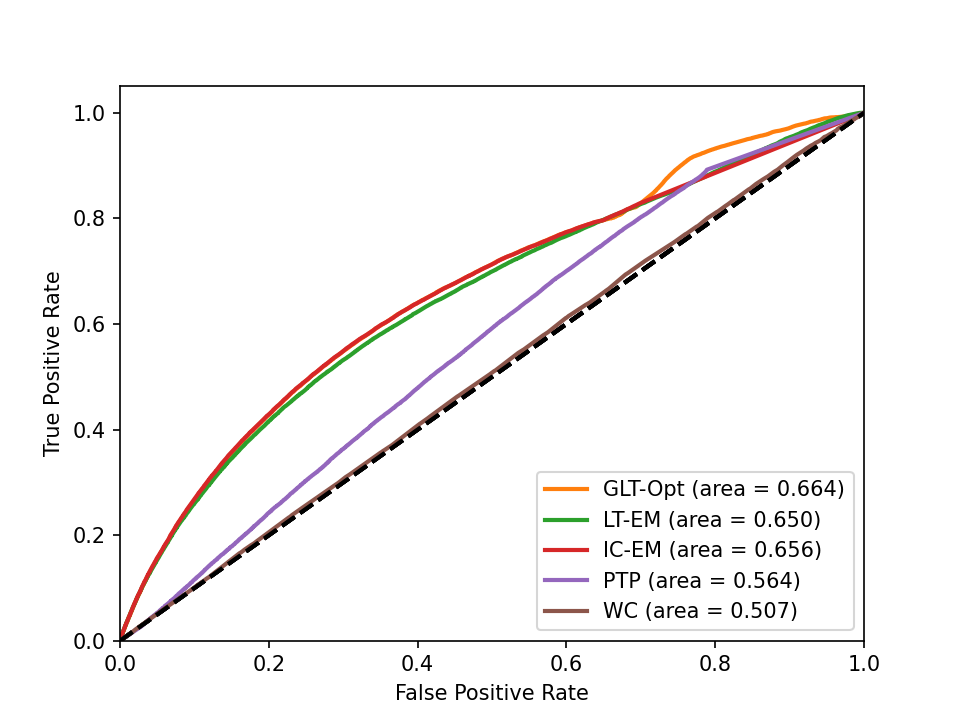

In [6]:
# for i, y in enumerate(ys):
#     for (model, ps), color in zip(ps_over_models.items(), colors):
#         plot_roc_auc(y, ps[i], label=model, color=color)
    
#     plt.title(None)
#     plt.show()

for (model, ps), color in zip(ps_over_models.items(), colors):
    plot_roc_auc(ys[0], ps[0], label=model, color=color)


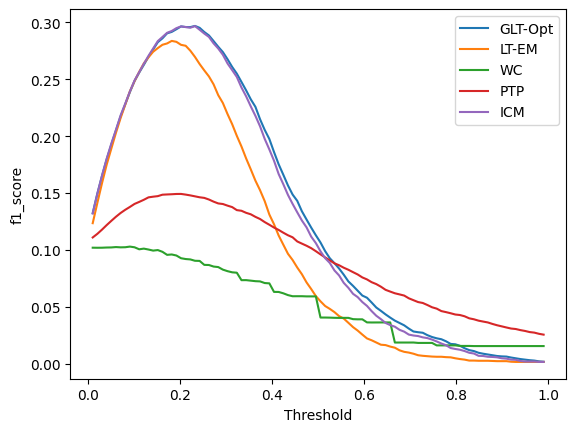

In [79]:
plot_metric_comparison_vs_threshold(ys[0], [ps[0] for ps in ps_over_models.values()],
                                    metric=f1_score,
                                    labels=model_labels,
                                    colors=colors)